# Imports

In [1]:
import zipfile
import os
import random
from pathlib import Path
import pandas as pd
import xml.etree.ElementTree as ET
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

# Reading Input Files

In [2]:
def zip2dir(input_zip, output_dir):
    # Ensure the directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Open the zip file
    with zipfile.ZipFile(input_zip, 'r') as zip_ref:
        # Extract all files
        zip_ref.extractall(output_dir)

> Unzipping input files

In [3]:
annot_dir = "Annotation/"
all_dogs = "all-dogs/"

zip2dir("/kaggle/input/generative-dog-images/Annotation.zip", "./")
zip2dir("/kaggle/input/generative-dog-images/all-dogs.zip", "./")

> Reading input files directories

In [4]:
all_dogs_files = [Path(all_dogs+i) for i in os.listdir(all_dogs)]
annot_files = [file for file in Path(annot_dir).rglob("*") if file.is_file()]

print(f"all_dogs_files: {all_dogs_files[:5]}")
print(f"annot_files: {annot_files[:5]}")

all_dogs_files: [PosixPath('all-dogs/n02113978_2888.jpg'), PosixPath('all-dogs/n02089973_255.jpg'), PosixPath('all-dogs/n02086079_8204.jpg'), PosixPath('all-dogs/n02097047_2701.jpg'), PosixPath('all-dogs/n02110806_3883.jpg')]
annot_files: [PosixPath('Annotation/n02105251-briard/n02105251_5074'), PosixPath('Annotation/n02105251-briard/n02105251_5570'), PosixPath('Annotation/n02105251-briard/n02105251_7233'), PosixPath('Annotation/n02105251-briard/n02105251_4893'), PosixPath('Annotation/n02105251-briard/n02105251_5303')]


> Creating DataFrame

In [5]:
tmp_map = {i.name: str(i) for i in annot_files}
input_file_dict = {str(i): tmp_map[i.stem] for i in all_dogs_files}

In [6]:
data = []

for k,v in input_file_dict.items():
    # Load and parse the XML file
    tree = ET.parse(v)  # Replace 'file.xml' with the path to your file
    root = tree.getroot()
    
    # Extract metadata
    folder = root.find('folder').text
    filename = root.find('filename').text
    database = root.find('source/database').text
    size = root.find('size')
    width = size.find('width').text
    height = size.find('height').text
    depth = size.find('depth').text
    
    # Extract object details and add metadata for each object
    for obj in root.findall('object'):
        name = obj.find('name').text
        pose = obj.find('pose').text
        truncated = obj.find('truncated').text
        difficult = obj.find('difficult').text
        bndbox = obj.find('bndbox')
        xmin = bndbox.find('xmin').text
        ymin = bndbox.find('ymin').text
        xmax = bndbox.find('xmax').text
        ymax = bndbox.find('ymax').text
    
        # Add a row for each object
        data.append({
            "ImageDirectory": k,
            "AnnotationDirectory": v,
            'Folder': folder,
            'Filename': filename,
            'Database': database,
            'Width': width,
            'Height': height,
            'Depth': depth,
            'ObjectName': name,
            'Pose': pose,
            'Truncated': truncated,
            'Difficult': difficult,
            'XMin': xmin,
            'YMin': ymin,
            'XMax': xmax,
            'YMax': ymax
        })

# Create DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
df.head()

,ImageDirectory,AnnotationDirectory,Folder,Filename,Database,Width,Height,Depth,ObjectName,Pose,Truncated,Difficult,XMin,YMin,XMax,YMax
0,all-dogs/n02113978_2888.jpg,Annotation/n02113978-Mexican_hairless/n0211397...,02113978,n02113978_2888,ImageNet database,350,376,3,Mexican_hairless,Unspecified,0,0,16,1,340,375
1,all-dogs/n02089973_255.jpg,Annotation/n02089973-English_foxhound/n0208997...,%s,%s,ILSVRC_2011,250,251,3,English_foxhound,NULL,0,0,47,41,249,223
2,all-dogs/n02086079_8204.jpg,Annotation/n02086079-Pekinese/n02086079_8204,02086079,n02086079_8204,ImageNet database,190,200,3,Pekinese,Unspecified,0,0,0,44,189,192
3,all-dogs/n02097047_2701.jpg,Annotation/n02097047-miniature_schnauzer/n0209...,02097047,n02097047_2701,ImageNet database,288,266,3,miniature_schnauzer,Unspecified,0,0,0,19,273,265
4,all-dogs/n02110806_3883.jpg,Annotation/n02110806-basenji/n02110806_3883,02110806,n02110806_3883,ImageNet database,500,396,3,basenji,Unspecified,0,0,48,14,483,379


> Little EDA

In [7]:
# General info about the DataFrame
print(df.info())

# Summary statistics of numeric columns
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22125 entries, 0 to 22124
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ImageDirectory       22125 non-null  object
 1   AnnotationDirectory  22125 non-null  object
 2   Folder               22125 non-null  object
 3   Filename             22125 non-null  object
 4   Database             22125 non-null  object
 5   Width                22125 non-null  object
 6   Height               22125 non-null  object
 7   Depth                22125 non-null  object
 8   ObjectName           22125 non-null  object
 9   Pose                 22125 non-null  object
 10  Truncated            22125 non-null  object
 11  Difficult            22125 non-null  object
 12  XMin                 22125 non-null  object
 13  YMin                 22125 non-null  object
 14  XMax                 22125 non-null  object
 15  YMax                 22125 non-null  object
dtypes: o

In [8]:
# Check for missing values
print(df.isnull().sum())

# Find unique values in categorical columns
for col in ['Folder', 'Database', 'ObjectName', 'Pose']:
    print(f"Unique values in {col}: {df[col].unique()}")

ImageDirectory         0
AnnotationDirectory    0
Folder                 0
Filename               0
Database               0
Width                  0
Height                 0
Depth                  0
ObjectName             0
Pose                   0
Truncated              0
Difficult              0
XMin                   0
YMin                   0
XMax                   0
YMax                   0
dtype: int64
Unique values in Folder: ['02113978' '%s' '02086079' '02097047' '02110806' '02109961' '02113799'
 '02091032' '02113186' '02099849' '02094114' '02108551' '02105251'
 '02091244' '02106382' '02097658' '02089078' '02087394' '02106030'
 '02106550' '02100735' '02102177' '02115641' '02110958' '02098413'
 '02097209' '02110185' '02106166' '02112137' '02110063' '02100583'
 '02110627' '02096051' '02109047' '02102040' '02088632' '02086240'
 '02087046' '02101006' '02094433' '02092002' '02088238' '02113023'
 '02096177' '02086910' '02096437' '02095889' '02097298' '02088094'
 '02100877' '02099601

ObjectName
Afghan_hound          287
Maltese_dog           264
Irish_wolfhound       263
Leonberg              256
Scottish_deerhound    246
                     ... 
Rottweiler            153
Brabancon_griffon     153
groenendael           152
Pekinese              152
redbone               151
Name: count, Length: 120, dtype: int64


<Axes: title={'center': 'Object Name Distribution'}, xlabel='ObjectName'>

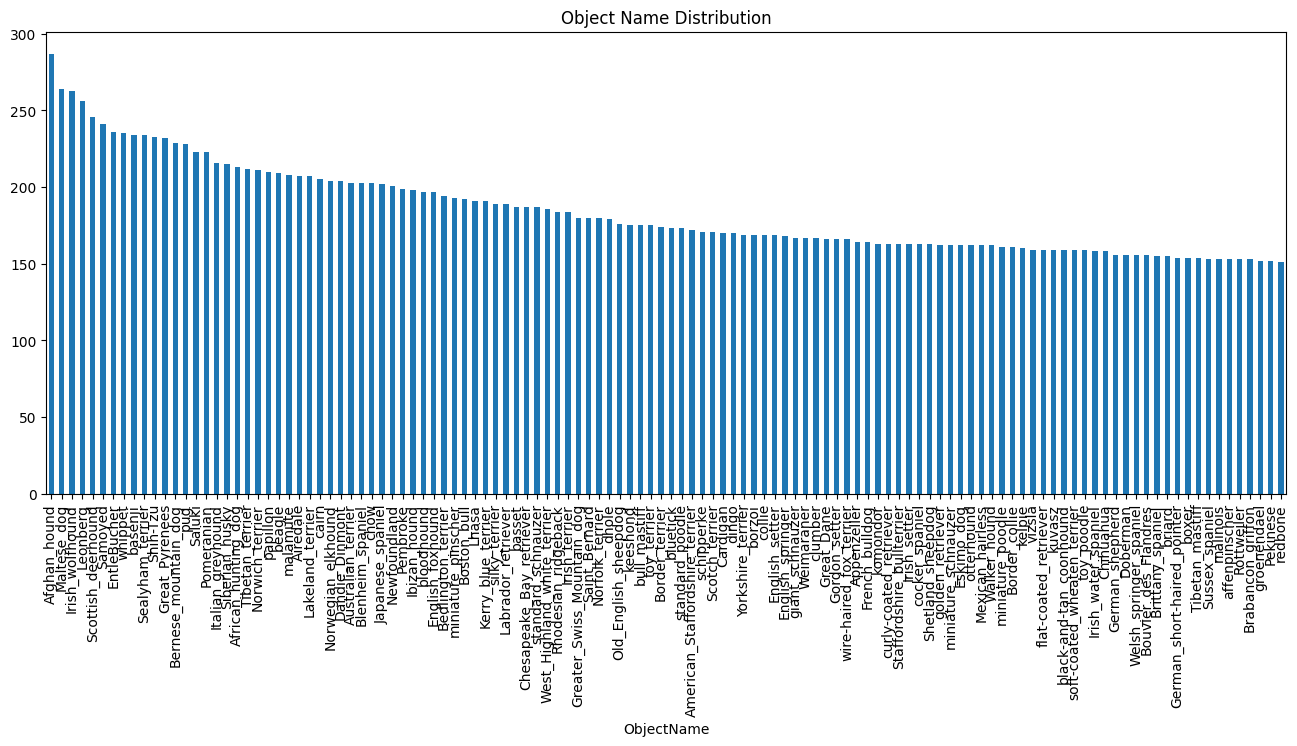

In [9]:
# Count occurrences of each object name
object_counts = df['ObjectName'].value_counts()
print(object_counts)

# Plot the distribution
object_counts.plot(kind='bar', title='Object Name Distribution', figsize=(16, 6))

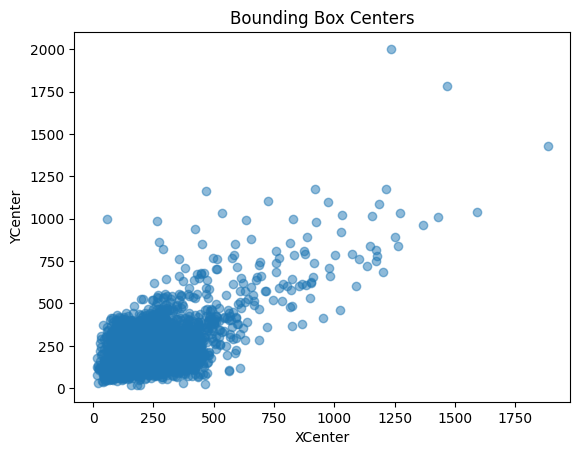

In [10]:
df['XCenter'] = (df['XMin'].astype(int) + df['XMax'].astype(int)) / 2
df['YCenter'] = (df['YMin'].astype(int) + df['YMax'].astype(int)) / 2

# Plot centers
import matplotlib.pyplot as plt

plt.scatter(df['XCenter'], df['YCenter'], alpha=0.5)
plt.title('Bounding Box Centers')
plt.xlabel('XCenter')
plt.ylabel('YCenter')
plt.show()

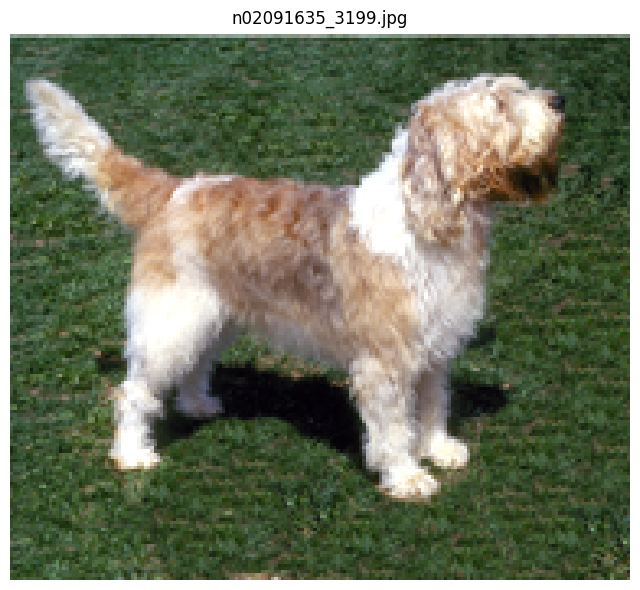

In [11]:
import torchvision.io as io

def denormalize(tensor, mean, std):
    """
    Denormalize a normalized tensor image back to the [0, 1] range for visualization.
    Args:
        tensor (torch.Tensor): The normalized image tensor.
        mean (list): Mean values used for normalization (per channel).
        std (list): Standard deviation values used for normalization (per channel).
    Returns:
        torch.Tensor: Denormalized image tensor in range [0, 1].
    """
    # Input validation
    if not isinstance(tensor, torch.Tensor):
        raise TypeError("Input must be a torch.Tensor")
    if tensor.dim() != 3:
        raise ValueError("Input must be a 3D tensor (C,H,W)")
        
    # Convert to float if needed
    tensor = tensor.float()
    
    # Reshape mean and std for broadcasting
    mean = torch.tensor(mean, dtype=tensor.dtype, device=tensor.device).view(3, 1, 1)
    std = torch.tensor(std, dtype=tensor.dtype, device=tensor.device).view(3, 1, 1)
    
    # Denormalize
    tensor = tensor * std + mean
    
    # Clamp values to [0, 1] range
    tensor = torch.clamp(tensor, 0, 1)
    
    return tensor

def show_image(image_path, denorm=False, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    """
    Display a single image given its path.
    Args:
        image_path (str): Path to the image file.
        denorm (bool): Whether to denormalize the image.
        mean (list): Mean values used for normalization.
        std (list): Standard deviation values used for normalization.
    """
    try:
        # Read image and convert to float
        img = io.read_image(image_path).float()
        
        # Normalize to [0, 1] range
        if img.max() > 1.0:
            img = img / 255.0
            
        # Apply denormalization if requested
        if denorm:
            img = denormalize(img, mean, std)
        
        # Convert to numpy and display
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
        plt.title(image_path.split('/')[-1])
        plt.show()
        
    except Exception as e:
        print(f"Error: {e}")

# Example usage
random_image_path = df.sample().iloc[0]['ImageDirectory']
show_image(random_image_path)

## Analyzing BBoxes

In [12]:
# Assuming `df` is your DataFrame
df['XMin'] = pd.to_numeric(df['XMin'], errors='coerce')
df['XMax'] = pd.to_numeric(df['XMax'], errors='coerce')
df['YMin'] = pd.to_numeric(df['YMin'], errors='coerce')
df['YMax'] = pd.to_numeric(df['YMax'], errors='coerce')
df['BoundingBoxArea'] = (df['XMax'] - df['XMin']) * (df['YMax'] - df['YMin'])

In [13]:
df.to_csv("data.csv", index=False)

Bounding Box and Image Statistics:
        Bounding Box Widths  Bounding Box Heights  Image Widths  Image Heights
Min               17.000000             18.000000     97.000000     100.000000
Max             2735.000000           2025.000000   3264.000000    2562.000000
Mean             281.385763            290.686192    444.477424     384.812927
Median           270.000000            285.000000    500.000000     375.000000
StdDev           129.295807            120.695808    141.474519     123.639943


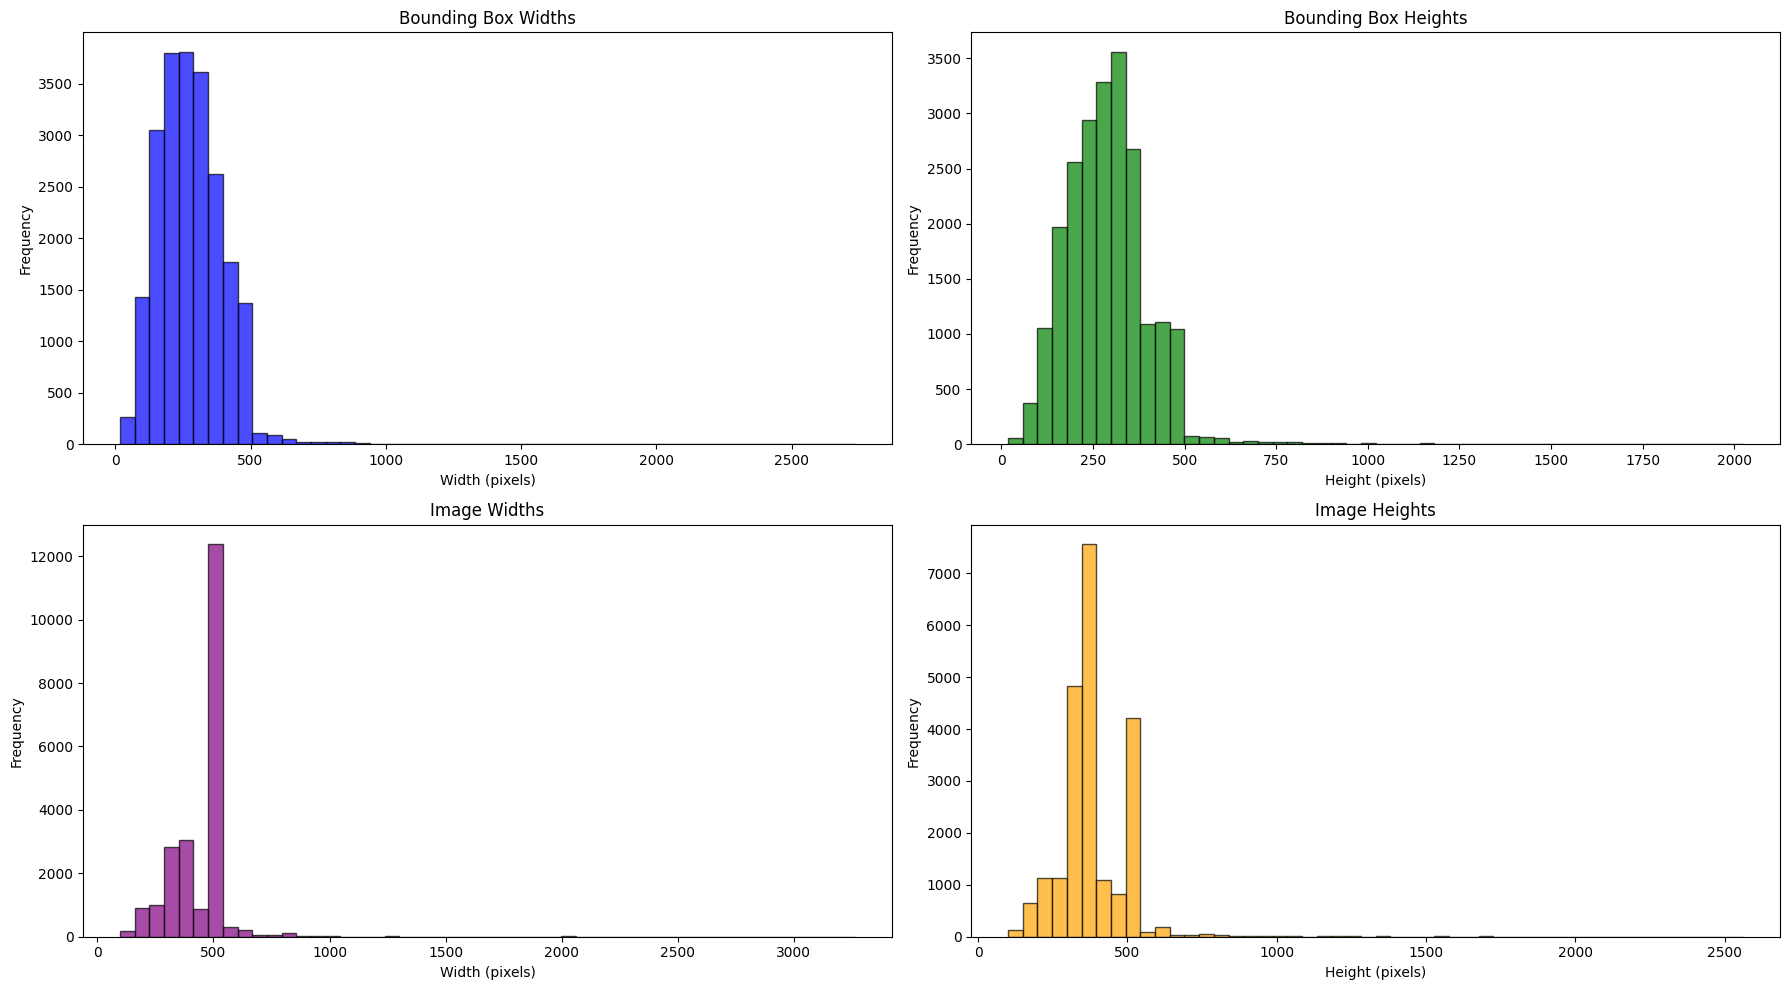

In [14]:
# Convert relevant columns to numeric types
columns_to_convert = ['XMax', 'XMin', 'YMax', 'YMin', 'BoundingBoxArea', 'Width', 'Height',]
for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Remove rows with invalid numeric data
bbox_data = df.dropna(subset=columns_to_convert)

# Extract bounding box dimensions
bbox_widths = bbox_data['XMax'] - bbox_data['XMin']
bbox_heights = bbox_data['YMax'] - bbox_data['YMin']
bbox_areas = bbox_data['BoundingBoxArea']
image_widths = bbox_data['Width']
image_heights = bbox_data['Height']

# Summarize statistics
summary = {
    "Bounding Box Widths": {
        "Min": bbox_widths.min(),
        "Max": bbox_widths.max(),
        "Mean": bbox_widths.mean(),
        "Median": bbox_widths.median(),
        "StdDev": bbox_widths.std()
    },
    "Bounding Box Heights": {
        "Min": bbox_heights.min(),
        "Max": bbox_heights.max(),
        "Mean": bbox_heights.mean(),
        "Median": bbox_heights.median(),
        "StdDev": bbox_heights.std()
    },
    "Image Widths": {
        "Min": image_widths.min(),
        "Max": image_widths.max(),
        "Mean": image_widths.mean(),
        "Median": image_widths.median(),
        "StdDev": image_widths.std()
    },
    "Image Heights": {
        "Min": image_heights.min(),
        "Max": image_heights.max(),
        "Mean": image_heights.mean(),
        "Median": image_heights.median(),
        "StdDev": image_heights.std()
    }
}

# Convert the summary to a DataFrame
summary_df = pd.DataFrame(summary)

# Display statistics
print("Bounding Box and Image Statistics:")
print(summary_df)

# Plot histograms for bounding boxes and image dimensions
plt.figure(figsize=(18, 10))

# Bounding box widths
plt.subplot(2, 2, 1)
plt.hist(bbox_widths, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title('Bounding Box Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

# Bounding box heights
plt.subplot(2, 2, 2)
plt.hist(bbox_heights, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.title('Bounding Box Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

# Image widths
plt.subplot(2, 2, 3)
plt.hist(image_widths, bins=50, alpha=0.7, color='purple', edgecolor='black')
plt.title('Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

# Image heights
plt.subplot(2, 2, 4)
plt.hist(image_heights, bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.title('Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Decision on Image Dimension Selection

After analyzing the statistics and distributions of bounding box widths, heights, and image dimensions, I have decided to standardize the image dimension to **256 pixels**. This decision is based on the following considerations:

1. **Divisibility by 2**: A dimension of 256 is divisible by 2 repeatedly, making it highly compatible with deep learning architectures that often involve downsampling operations.
2. **Ease of Handling**: 256 pixels is a manageable size that balances computational efficiency and sufficient detail retention for the task.
3. **Consistency**: Standardizing dimensions ensures uniformity in data preprocessing, improving the model's performance and interpretability.

This standardized dimension will be used for resizing all images before processing them further.

100%|██████████| 22125/22125 [04:53<00:00, 75.47it/s]


Processing complete! Data saved in 'image_paths.csv'.


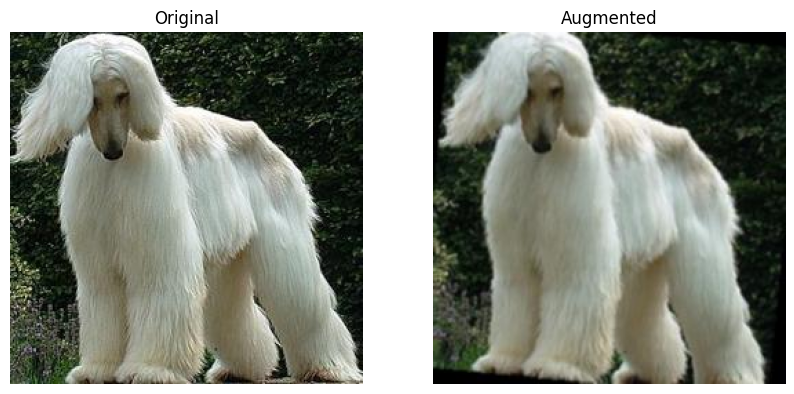

In [15]:
import os
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch

# Directories for saving images
os.makedirs("original_images", exist_ok=True)
os.makedirs("augmented_images", exist_ok=True)

# Define normalization parameters
MEAN = [0.5, 0.5, 0.5]
STD = [0.5, 0.5, 0.5]

# Transforms
crop_transform = transforms.Compose([
    transforms.Resize((256, 256))  # Crop and resize centered at BBox
])

augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.GaussianBlur(kernel_size=(3, 7), sigma=(0.1, 2.0)),  # Added blur
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)  # Apply normalization
])

def denormalize(tensor):
    """
    Denormalize a tensor image with fixed mean and std
    """
    tensor = tensor.clone()  # Avoid modifying the original tensor
    for t, m, s in zip(tensor, MEAN, STD):
        t.mul_(s).add_(m)
    return tensor.clamp_(0, 1)  # Clamp to [0,1] range

# DataFrame to store results
result = []
for idx, row in tqdm(df.iterrows(), total=len(df)):
    img_path = row['ImageDirectory']
    object_name = row['ObjectName']
    x_center, y_center = row['XCenter'], row['YCenter']
    width, height = row['Width'], row['Height']
    bbox_width, bbox_height = row['XMax'] - row['XMin'], row['YMax'] - row['YMin']
    
    try:
        # Open and crop image
        img = Image.open(img_path).convert("RGB")
        left = max(0, x_center - bbox_width // 2)
        upper = max(0, y_center - bbox_height // 2)
        right = min(width, x_center + bbox_width // 2)
        lower = min(height, y_center + bbox_height // 2)
        cropped_img = img.crop((left, upper, right, lower)).resize((256, 256))
        
        # Save original cropped image
        original_path = f"original_images/{os.path.basename(img_path)}"
        cropped_img.save(original_path)
        
        # Apply augmentations
        aug_img = augment_transform(cropped_img)  # Returns normalized tensor
        
        # Denormalize before saving
        aug_img_denorm = denormalize(aug_img)
        
        # Convert to PIL and save
        aug_img_pil = transforms.ToPILImage()(aug_img_denorm)
        augmented_path = f"augmented_images/{os.path.basename(img_path)}"
        aug_img_pil.save(augmented_path)
        
        # Append to result DataFrame
        result.append({
            "OriginalImagePath": original_path,
            "AugmentedImagePath": augmented_path,
            "ObjectName": object_name
        })
        
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        continue

# Create DataFrame
final_df = pd.DataFrame(result)
final_df.to_csv("image_paths.csv", index=False)
print("Processing complete! Data saved in 'image_paths.csv'.")

# Function to view results
def view_pair(row_idx, final_df):
    """
    Display original and augmented image pair
    """
    import matplotlib.pyplot as plt
    
    row = final_df.iloc[row_idx]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    # Display original
    img1 = Image.open(row['OriginalImagePath'])
    ax1.imshow(img1)
    ax1.set_title('Original')
    ax1.axis('off')
    
    # Display augmented
    img2 = Image.open(row['AugmentedImagePath'])
    ax2.imshow(img2)
    ax2.set_title('Augmented')
    ax2.axis('off')
    
    plt.show()

# View a random pair
random_idx = np.random.randint(len(final_df))
view_pair(random_idx, final_df)

In [16]:
final_df

,OriginalImagePath,AugmentedImagePath,ObjectName
0,original_images/n02113978_2888.jpg,augmented_images/n02113978_2888.jpg,Mexican_hairless
1,original_images/n02089973_255.jpg,augmented_images/n02089973_255.jpg,English_foxhound
2,original_images/n02086079_8204.jpg,augmented_images/n02086079_8204.jpg,Pekinese
3,original_images/n02097047_2701.jpg,augmented_images/n02097047_2701.jpg,miniature_schnauzer
4,original_images/n02110806_3883.jpg,augmented_images/n02110806_3883.jpg,basenji
...,...,...,...
22120,original_images/n02086079_22412.jpg,augmented_images/n02086079_22412.jpg,Pekinese
22121,original_images/n02107312_6924.jpg,augmented_images/n02107312_6924.jpg,miniature_pinscher
22122,original_images/n02099849_3289.jpg,augmented_images/n02099849_3289.jpg,Chesapeake_Bay_retriever
22123,original_images/n02107574_976.jpg,augmented_images/n02107574_976.jpg,Greater_Swiss_Mountain_dog


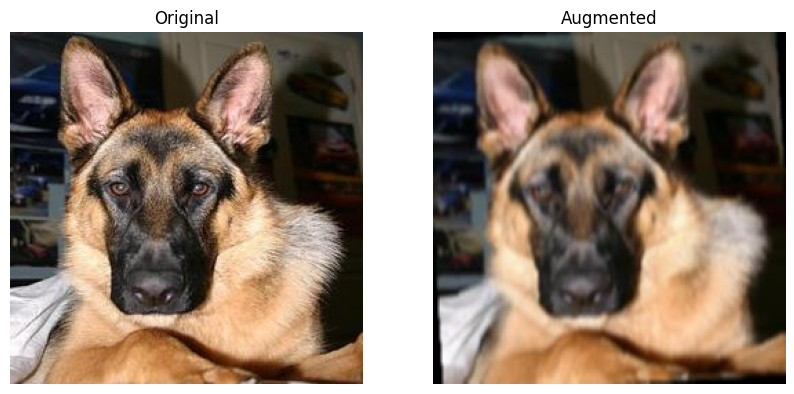

In [17]:
# View a random pair
random_idx = np.random.randint(len(final_df))
view_pair(random_idx, final_df)

# Building Model
This section outlines the steps to build a Conditional Variational Autoencoder (C-VAE) for generating new dog images using PyTorch.

In [18]:
import torch
from torch import nn
import torchvision


class Encoder(nn.Module):
    def __init__(self, in_channels, feature_dim, latent_dim):
        super(Encoder, self).__init__()
        self.in_channels = in_channels
        self.feature_dim = feature_dim
        self.latent_dim  = latent_dim

        self.intermediate_layers = nn.Sequential(
            nn.Conv2d(in_channels, 16, 4, 2, 2), # [3, 256, 256] -> [16, 128, 128]
            nn.BatchNorm2d(16), # [16, 128, 128] -> [16, 128, 128]
            nn.SiLU(),
            
            nn.Conv2d(16, 32, 4, 2, 2), # [16, 128, 128] -> [32, 64, 64]
            nn.BatchNorm2d(32), # [32, 64, 64] -> [32, 64, 64]
            nn.SiLU(),
            
            nn.Conv2d(32, 64, 4, 2, 2), # [32, 64, 64] -> [64, 32, 32]
            nn.BatchNorm2d(64), # [64, 32, 32] -> [64, 32, 32]
            nn.SiLU(),
            nn.MaxPool2d(2, 2), # [64, 32, 32] -> [64, 16, 16]
            
            nn.Conv2d(64, 128, 4, 2, 2), # [64, 16, 16] -> [128, 8, 8]
            nn.BatchNorm2d(128), # [128, 8, 8] -> [128, 8, 8]
            nn.SiLU(),
            nn.MaxPool2d(2, 2), # [128, 8, 8] -> [128, 4, 4]

            nn.Conv2d(128, latent_dim*2, 3, 1, 1, bias=False), # [128, 4, 4] -> [latent_dim*2, 4, 4]
            nn.BatchNorm2d(latent_dim*2), # [latent_dim*2, 4, 4] -> [latent_dim*2, 4, 4]
            nn.SiLU()
        )

    def forward(self, x):
        x = self.intermediate_layers(x)
        return x[:, :self.latent_dim, :, :], x[:, self.latent_dim:, :, :]


class Decoder(nn.Module):
    def __init__(self, in_channels, feature_dim, latent_dim):
        super(Decoder, self).__init__()
        self.in_channels = in_channels
        self.feature_dim = feature_dim
        self.latent_dim  = latent_dim

        self.intermediate_layers = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, 4, 2, 1), # [latent_dim, 4, 4] -> [128, 8, 8]
            nn.BatchNorm2d(128), # [128, 8, 8] -> [128, 8, 8]
            nn.SiLU(),
            
            nn.ConvTranspose2d(128, 64, 4, 2, 1), # [128, 8, 8] -> [64, 16, 16]
            nn.BatchNorm2d(64), # [64, 16, 16] -> [64, 16, 16]
            nn.SiLU(),
            
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # [64, 16, 16] -> [32, 32, 32]
            nn.BatchNorm2d(32), # [32, 32, 32] -> [32, 32, 32]
            nn.SiLU(),
            
            nn.ConvTranspose2d(32, 16, 4, 2, 1), # [32, 32, 32] -> [16, 64, 64]
            nn.BatchNorm2d(16), # [16, 64, 64] -> [16, 64, 64]
            nn.SiLU(),

            nn.ConvTranspose2d(16, 8, 4, 2, 1), # [16, 64, 64] -> [8, 128, 128]
            nn.BatchNorm2d(8), # [8, 128, 128] -> [8, 128, 128]
            nn.SiLU(),

            nn.Conv2d(8, 3, 4, 2, 1), # [8, 128, 128] -> [3, 256, 256]
            nn.BatchNorm2d(3), # [3, 256, 256] -> [3, 256, 256]
            nn.SiLU(),
        )

        
    def forward(self, x):
        x = self.intermediate_layers(x)
        return x


class VAE(nn.Module):
    def __init__(self, in_channels, feature_dim, latent_dim, cond_dim, n_conditions):
        super(VAE, self).__init__()
        self.in_channels = in_channels
        self.feature_dim = feature_dim      
        self.latent_dim  = latent_dim

        self.encoder = Encoder(in_channels, feature_dim, latent_dim)
        self.decoder = Decoder(in_channels, feature_dim, latent_dim + cond_dim)

        # Learnable embeddings for conditions
        self.condition_embeddings = nn.Embedding(n_conditions, cond_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x, condition):
        mu, logvar = self.encoder(x)
        # Reparametrizing trick
        z = self.reparameterize(mu, logvar)

        # Add condition embedding
        cond_embedding = self.condition_embeddings(condition).squeeze()  # (batch_size, cond_dim)
        
        cond_embedding = cond_embedding.unsqueeze(-1).unsqueeze(-1)  # (batch_size, cond_dim, 1, 1)
        cond_embedding = cond_embedding.expand(-1, -1, 4, 4)  # Expand for concatenation
        
        z_cond = torch.cat([z, cond_embedding], dim=1)
        print(z_cond.shape)
        # Decode
        reconstructed = self.decoder(z_cond)
        return reconstructed, mu, logvar

In [19]:
model = VAE(3, 256, 128, 16, 10)